**Create Hexbins of a given city and export population and tree cover maps**

In [14]:
# Import packages
import geopandas as gpd , os , geemap , ee 
import osmnx as ox
from shapely.geometry import box
from rasterio.plot import show
import pylab as plt
from geopandas.tools import sjoin
import contextily as cx
from h3 import h3
import h3pandas
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
from rasterio.crs import CRS
import matplotlib.colors as colors


In [15]:
def set_paths(base_dir):
    data = os.path.join(base_dir, 'data') 
    output = os.path.join(base_dir, 'output') 
    shapefiles = os.path.join(output, 'shapefiles') 
    maps = os.path.join(output, 'maps') 
    rasters = os.path.join(output, 'rasters') 
    
    dirs_list= [ shapefiles , maps , rasters]
    for dir in dirs_list:
        if not os.path.exists(dir):
            os.mkdir(dir)

    return shapefiles , maps , rasters

base_dir = 'C:/Users/Aziz/Dropbox/CRP/UHI'
shapefiles , maps , rasters= set_paths(base_dir)

Initialize ee and import shapefile and select city

In [16]:
ee.Initialize()
WGS84=4326
EPSG_str= 'EPSG:4326'
city= "Phnom Penh"
gdf_WA = gpd.read_file(f'{shapefiles}/khm_admbnda_adm1_gov_20181004.shp').to_crs(WGS84)
gdf_WA=gdf_WA[gdf_WA["ADM1_EN"] == city]

In [17]:
def create_hexbins_and_geom_features(gdf_WA, hexbin_res, WGS84):
    poly = gdf_WA.geometry.unary_union
    gdf_boundary = gpd.GeoDataFrame(geometry=[poly],crs=gdf_WA.crs)
    # gdf_h3 = gdf_boundary.h3.polyfill(9,explode=True)
    gdf_h3 = gdf_boundary.h3.polyfill(hexbin_res,explode=True)
    gdf_h3 = gdf_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary()
    output_shapefile= f'{shapefiles}/h3_grid.shp'
    gdf_h3.to_file(output_shapefile)
    hexbins_projected = gpd.read_file(output_shapefile).to_crs(WGS84)

    geom = gdf_boundary['geometry']
    jsonDict = eval(geom.to_json())
    for index, row in gdf_boundary.iterrows(): 
        polygon_list= []
        for x in jsonDict['features'][index]['geometry']['coordinates']:
            polygon_list.append(x)
            region = ee.Geometry.Polygon(polygon_list)
            fc_filtered = ee.FeatureCollection(region)
            
    gdf_h3.plot()

    return fc_filtered  , region , hexbins_projected

In [18]:
# Change colormap by truncating
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [19]:
def zonal_stats_tree_cover(ee , EPSG_str):

    tree_cover=ee.ImageCollection("projects/sat-io/open-datasets/GFCC30TC") \
        .limit(1, 'system:time_start', False).first().clip(fc_filtered)

    tif = os.path.join(rasters, 'tree_cover_projected.tif')
    geemap.ee_export_image(
        tree_cover, filename=tif,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=30, region=region, file_per_band=False
    )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected['tree_cover_sum'] = zonal_stats(hexbins_projected, tif ,stats='sum')
    hexbins_projected['tree_cover_sum'] = [item['sum'] for item in hexbins_projected['tree_cover_sum']]
    hexbins_projected['tree_cover_sum'].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected['tree_cover_sum'].idxmax()]['tree_cover_sum'])
    
    return hexbins_projected , max



In [20]:
def clipToCol(image):
  """clip gee collection
  args:
      image: Image collection
  returns:
    ee-collection: Clipped image collection
   
   """
  return image.clip(fc_filtered)

In [21]:
def export_map(map_dir, hexagons, crs,cmap,  visualize_column, title):
    ax = hexagons.to_crs(crs).plot(figsize=(12, 12) ,vmin=0,  vmax=int(max/4) , \
                                   alpha=0.6, column=visualize_column, \
                                    cmap=cmap,legend=True, \
                                        legend_kwds={'shrink': 0.77, 'orientation': 'vertical', \
                                                      'location': 'right', 'label': f'{title}', \
                                                        'pad':0.009})

    gdf_WA.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs) 
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs) # zoom=13
    plt.title(f'{title}',fontsize=20)
    plt.xticks([])
    plt.yticks([])
        
    ax.figure.set_size_inches(12, 12)
    plt.tight_layout()
    ax.figure.savefig(f"{map_dir}/{city}_{visualize_column}_truncated_cmap_max_div_4.png")


In [22]:
def zonal_stats_pop_density(ee , EPSG_str):
    #  Define WorldPop & clip using function 
    pop_density = ee.ImageCollection("WorldPop/GP/100m/pop").map(clipToCol). \
                    filterDate('2020').select('population').mosaic()

    tif = os.path.join(rasters, 'pop_density_projected.tif')
    geemap.ee_export_image( pop_density, 
                           filename=tif,  
                           crs=EPSG_str,
                           # crs_transform=crs_transform,
                           scale=100, 
                           region=region, 
                           file_per_band=False
                           )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected['pop_density_sum'] = zonal_stats(hexbins_projected, tif ,stats='sum')
    hexbins_projected['pop_density_sum'] = [item['sum'] for item in hexbins_projected['pop_density_sum']]
    hexbins_projected['pop_density_sum'].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected['pop_density_sum'].idxmax()]['pop_density_sum'])
    
    return hexbins_projected , max

In [23]:
def calculate_trees_to_people_ratio(hexbins_projected):
    hexbins_projected['trees_div_people']= hexbins_projected[['tree_cover_sum']].div(hexbins_projected.pop_density_sum, axis=0) #.astype(int)
    hexbins_projected['trees_div_people']= hexbins_projected['trees_div_people'].apply("int64")
    max=int(hexbins_projected.loc[hexbins_projected['trees_div_people'].idxmax()]['trees_div_people'])
    return hexbins_projected , max


C:\Users\Aziz\AppData\Local\Temp\ipykernel_10600\3035060070.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_h3.to_file(output_shapefile)


Generating URL ...
Please wait ...
Data downloaded to C:\Users\Aziz\Dropbox\CRP\UHI\output\rasters\tree_cover_projected.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Aziz\Dropbox\CRP\UHI\output\rasters\pop_density_projected.tif


c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
c:\Users\Aziz\anaconda3\envs\uh\lib\site-packages\pandas\core\series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


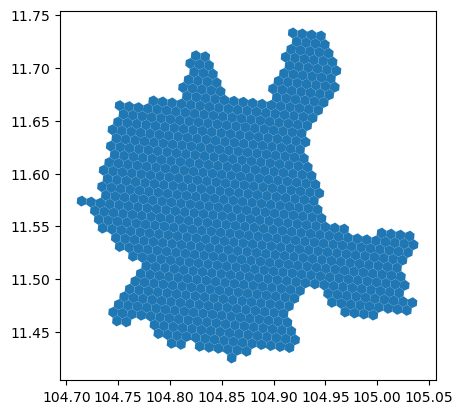

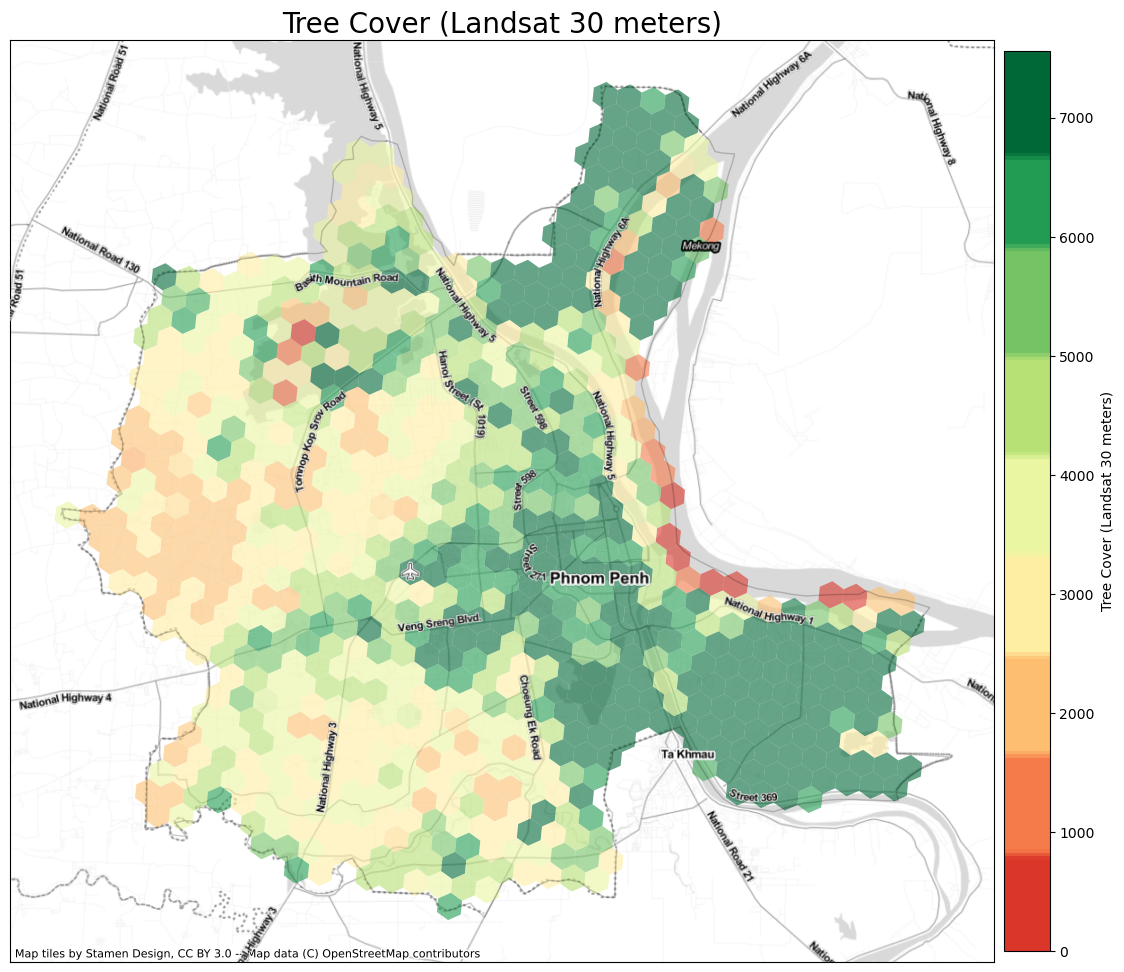

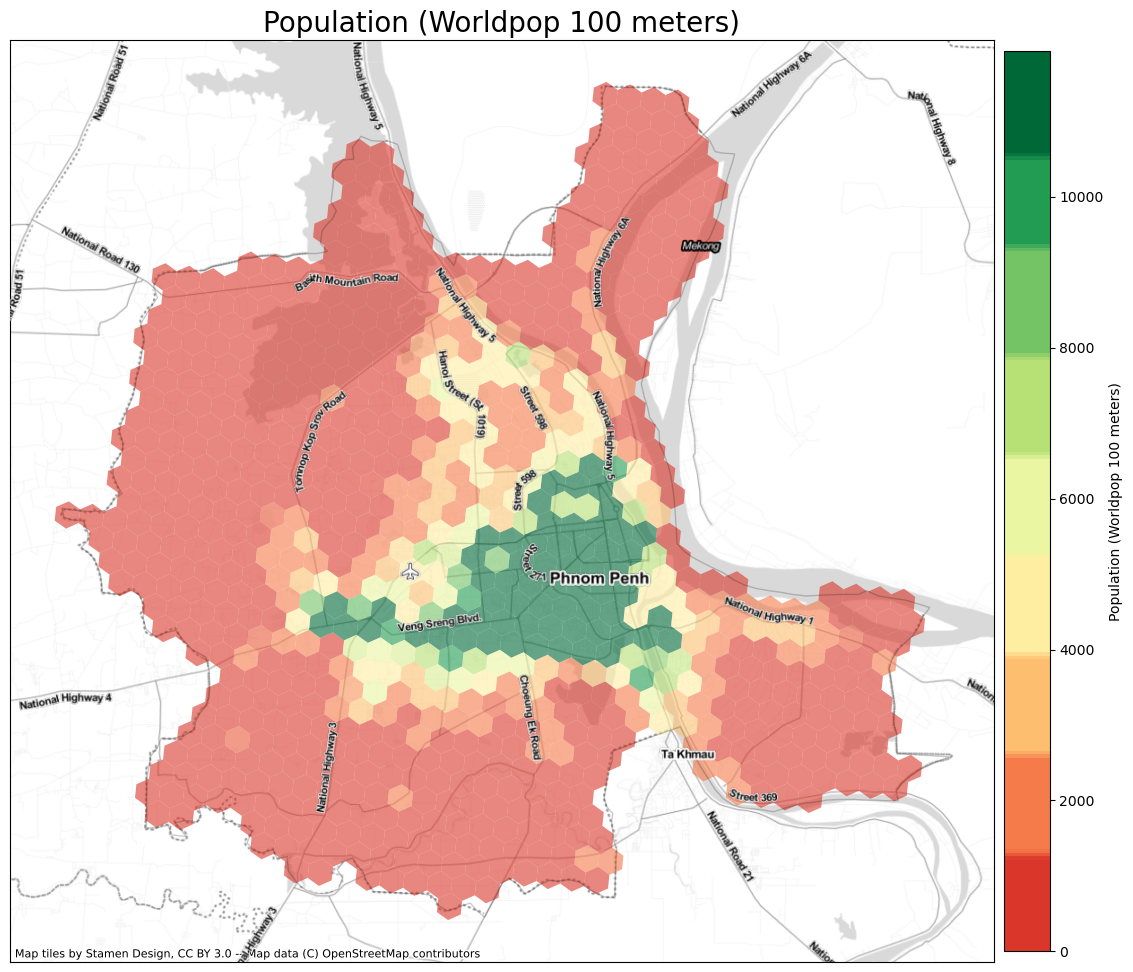

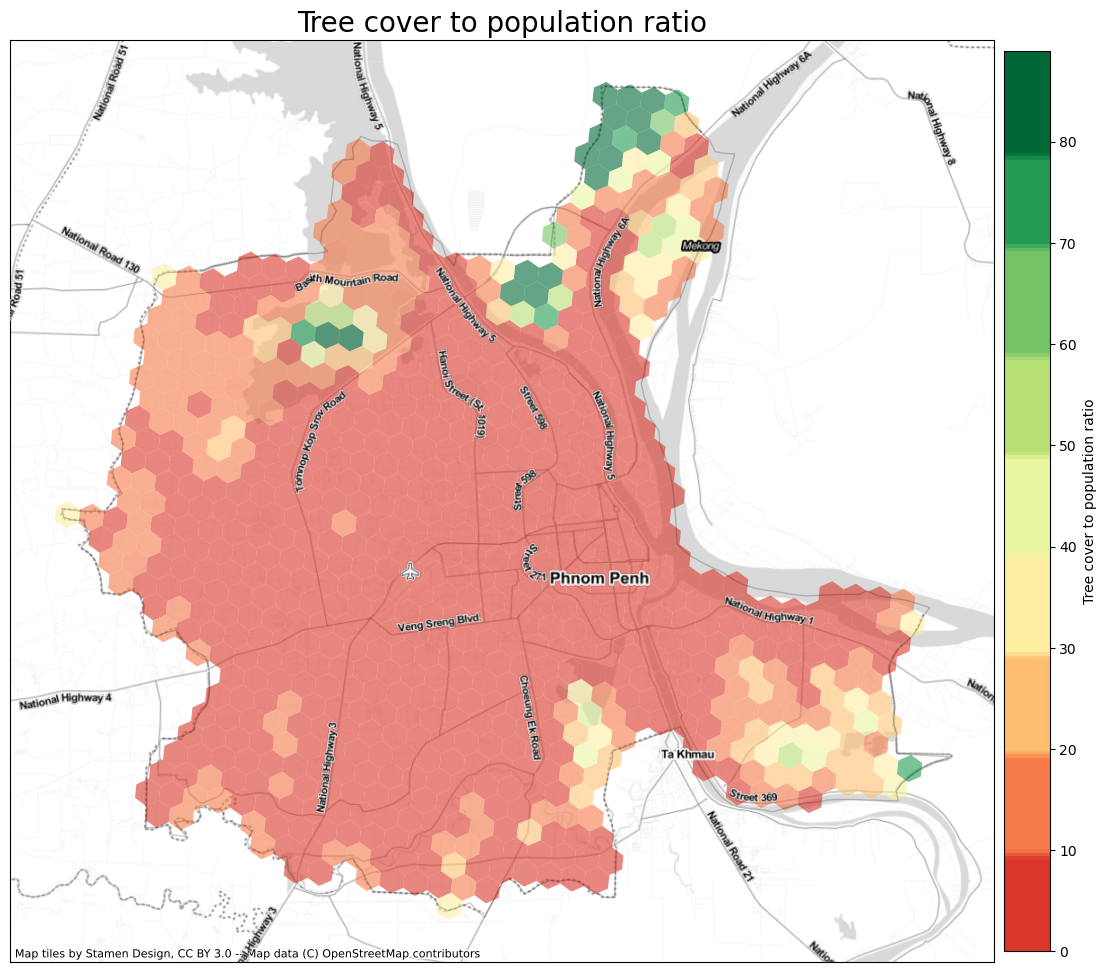

In [24]:

if __name__ == "__main__":
    fc_filtered  , region , hexbins_projected= create_hexbins_and_geom_features(gdf_WA, hexbin_res=8, WGS84=WGS84)
    hexbins_projected , max= zonal_stats_tree_cover(ee , EPSG_str)
    cmap = plt.get_cmap('RdYlGn', 10)
    cmap = truncate_colormap(cmap, 0.1, 1)
    export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='tree_cover_sum', title="Tree Cover (Landsat 30 meters)")
    hexbins_projected , max= zonal_stats_pop_density(ee , EPSG_str)
    cmap = plt.get_cmap('RdYlGn', 10)
    cmap = truncate_colormap(cmap, 0.1, 1)
    export_pop_density= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='pop_density_sum' , title="Population (Worldpop 100 meters)")
    hexbins_projected , max=calculate_trees_to_people_ratio(hexbins_projected)
    export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='trees_div_people', title="Tree cover to population ratio")

